# Kaggler's Guide to LightGBM Hyperparameter Tuning with Optuna in 2021
![](images/pixabay.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@pixabay?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pixabay</a>
        on 
        <a href='https://www.pexels.com/photo/silhouette-of-person-holding-sparkler-digital-wallpaepr-266429/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels.</a> All images are by the author unless specified otherwise.
    </strong>
</figcaption>

# Setup

In [6]:
import logging
import time
import warnings

import catboost as cb
import joblib
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S", level=logging.INFO
)

warnings.filterwarnings("ignore")

# Introduction

In the previous article, we talked about the basics of LightGBM and creating LGBM models that beat XGBoost in almost every aspect. This article focuses on the last stage of any machine learning project — hyperparameter tuning (if we omit model ensembling).

First, we will look at the most important LGBM hyperparameters, grouped by their impact level and area. Then, we will see a hands-on example of tuning LGBM parameters using Optuna — the next-generation bayesian hyperparameter tuning framework.

Most importantly, we will do this in a similar way to how top Kagglers tune their LGBM models that achieve impressive results.

> I highly suggest reading the [first part](https://www.kaggle.com/bextuychiev/how-to-beat-the-heck-out-of-xgboost-with-lightgbm) of the article if you are new to LGBM. Although I will briefly explain how Optuna works, I also recommend reading my [separate post](https://www.kaggle.com/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna) on it to get the best out this article.

# Overview of the most important parameters

Generally, hyperparameters of the most tree-based models can be grouped into 4 categories:
1. Parameters that affect the structure and learning of the decision trees
2. Parameters that affect the training speed
3. Parameters for better accuracy
4. Parameters to combat overfitting

Most of the time, these categories have a lot of overlap, and increasing efficiency in one may risk a decrease in another. That’s why tuning them manually is a giant mistake and should be avoided.

Frameworks like Optuna can automatically find the “sweet medium” between these categories if given a good enough parameter grid.

# Hyperparameters that control the tree structure

> If you are not familiar with decision trees, check out [this legendary video](https://www.youtube.com/watch?v=_L39rN6gz7Y) by StatQuest.

In LGBM, the most important parameter to control the tree structure is `num_leaves`. As the name suggests, it controls the number of decision leaves in a single tree. The decision leaf of a tree is the node where the 'actual decision' happens.

The next is `max_depth`. The higher `max_depth`, the more levels the tree has, which makes it more complex and prone to overfit. Too low, and you will underfit. Even though it sounds hard, it is the easiest parameter to tune — just choose a value between 3 and 12 (this range tends to work well on Kaggle for any dataset).

Tuning `num_leaves` can also be easy once you determine `max_depth`. There is a simple formula given in LGBM documentation - the maximum limit to `num_leaves` should be 2^(max_depth). This means the optimal value for `num_leaves` lies within the range $(2^3, 2^{12})$ or $(8, 4096)$.

However, `num_leaves` impacts the learning in LGBM more than `max_depth`. This means you need to specify a more conservative search range like (20, 3000) - that's what I mostly do.

Another important structural parameter for a tree is `min_data_in_leaf`. Its magnitude is also correlated to whether you overfit or not. In simple terms, `min_data_in_leaf` specifies the minimum number of observations that fit the decision criteria in a leaf.

For example, if the decision leaf checks whether one feature is greater than, let’s say, 13 — setting `min_data_in_leaf` to 100 means we want to evaluate this leaf only if at least 100 training observations are bigger than 13. This is the gist in my lay terms.

The optimal value for `min_data_in_leaf` depends on the number of training samples and `num_leaves`. For large datasets, set a value in hundreds or thousands.

Check out [this section](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#tune-parameters-for-the-leaf-wise-best-first-tree) of the LGBM documentation for more details.

# Hyperparameters for better accuracy

A common strategy for achieving higher accuracy is to use many decision trees and decrease the learning rate. In other words, find the best combination of `n_estimators` and `learning_rate` in LGBM.

`n_estimators` controls the number of decision trees while `learning_rate` is the step size parameter of the gradient descent.

Ensembles like LGBM build trees in iterations, and each new tree is used to correct the “errors” of the previous trees. This approach is fast and powerful, and prone to overfitting.

That’s why gradient boosted ensembles have a `learning_rate` parameter that controls the learning speed. Typical values lie within 0.01 and 0.3, but it is possible to go beyond these, especially towards 0.

So, the perfect setup for these 2 parameters (`n_estimators` and `learning_rate`) is to use many trees with early stopping and set a low value for `learning_rate`. We will see an example later.

You can also increase `max_bin` than the default (255) but again, at the risk of overfitting.

Check out [this section](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-better-accuracy) of the LGBM documentation for more details.

# More hyperparameters to control overfitting

LGBM also has important regularization parameters.

`lambda_l1` and `lambda_l2` specifies L1 or L2 regularization, like XGBoost's `reg_lambda` and `reg_alpha`. The optimal value for these parameters is harder to tune because their magnitude is not directly correlated with overfitting. However, a good search range is (0, 100) for both.

Next, we have `min_gain_to_split`, similar to XGBoost's `gamma`. A conservative search range is (0, 15). It can be used as extra regularization in large parameter grids.

Lastly, we have `bagging_fraction` and `feature_fraction`. `bagging_fraction` takes a value within (0, 1) and specifies the percentage of training samples to be used to train each tree (exactly like `subsample` in XGBoost). To use this parameter, you also need to set `bagging_freq` to an integer value, explanation [here](https://lightgbm.readthedocs.io/en/latest/Parameters.html#:~:text=frequency%20for%20bagging).

`feature_fraction` specifies the percentage of features to sample when training each tree. So, it also takes a value between (0, 1) - XGBoost alias is `colsample_bytree`.

We have already covered other parameters that affect overfitting (`max_depth`, `num_leaves`, etc.) in earlier sections.

# Creating the search grid in Optuna

The optimization process in Optuna requires a function called *objective* that:
- includes the parameter grid to search as a dictionary
- creates a model to try hyperparameter combination sets
- fits the model to the data with a single candidate set
- generates predictions using this model
- scores the predictions based on user-defined metric and returns it

Here is how it looks like in code:

In [4]:
import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold


def objective(trial, X, y):
    param_grid = {}  # to be filled in later
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = preds

    return np.mean(cv_scores)

In the above `objective` function, we haven't specified the grid yet.

It is optional, but we are performing training inside cross-validation. This ensures that each hyperparameter candidate set gets trained on full data and evaluated more robustly. It also enables us to use early stopping. At the last line, we are returning the mean of the CV scores, which we want to optimize.

Let’s focus on creating the grid now. We will include the hyperparameters introduced today with their recommended search ranges:

In [3]:
def objective(trial, X, y):
    param_grid = {
        #         "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    ...

> If you don't understand the above grid or the `trial` object, check out my [article](https://towardsdatascience.com/why-is-everyone-at-kaggle-obsessed-with-optuna-for-hyperparameter-tuning-7608fdca337c) on Optuna.

# Creating Optuna study and runing trials

It is time to start the search. Here is the full objective function for reference:

In [5]:
from optuna.integration import LightGBMPruningCallback


def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

To this grid, I also added `LightGBMPruningCallback` from Optuna's `integration` module. This callback class is handy - it can detect unpromising hyperparameter sets before training them on the data, reducing the search time significantly.

You should pass it to LGBM’s `fit` method under `callbacks` and set the `trial` object and the evaluation metric you are using as parameters.

Now, let’s create the study and run a few trials:

```python
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)
```

After the search is done, just call `best_value` and `bast_params` attributes and you will get an output similar to this:

```python
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")
    
-----------------------------------------------------
Best value (rmse): 0.34926
	Best params:
		device_type: gpu
		n_estimators: 10000
		learning_rate: 0.2423075935828885
		num_leaves: 2260
		max_depth: 9
		min_data_in_leaf: 8600
		lambda_l1: 70
		lambda_l2: 35
		min_gain_to_split: 0.11775633820897208
		bagging_fraction: 0.6000000000000001
		bagging_freq: 1
		feature_fraction: 0.6000000000000001
```

# Conclusion

That’s it! You are now a pro LGBM user. If you implement the things you learned in these two articles, believe me, you are already better than many Kagglers who use LightGBM.

That’s because you have a deeper understanding of how the library works, what its parameters represent, and skillfully tune them. This type of fundamental knowledge of a library is always better than rampant code reuse without an ounce of understanding.

To move from pro to master, I suggest spending some time on the [documentation](https://lightgbm.readthedocs.io/en/latest/index.html). Thank you for reading!

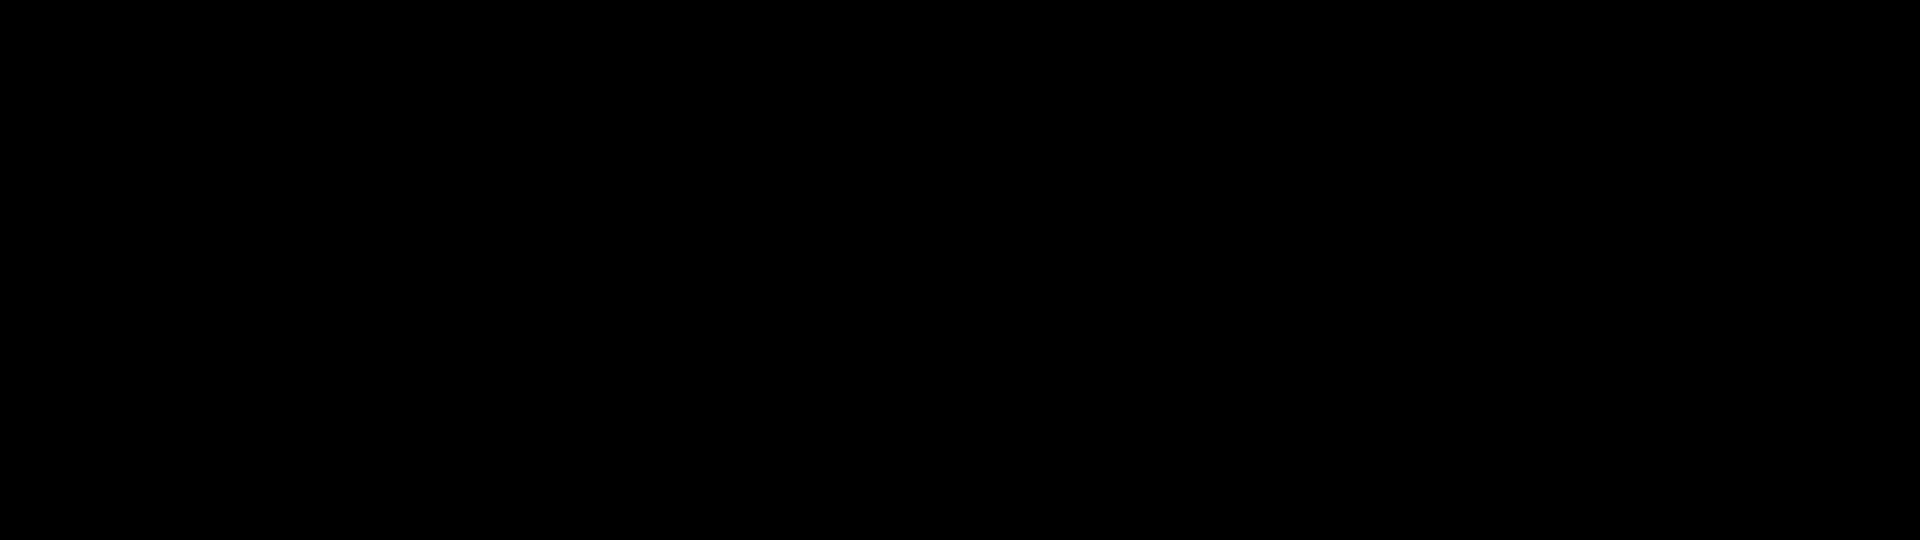

# You might also be interested...
- [Tired of Cliché Datasets? Here are 18 Awesome Alternatives From All Domains](https://towardsdatascience.com/tired-of-clich%C3%A9-datasets-here-are-18-awesome-alternatives-from-all-domains-196913161ec9)
- [Love 3Blue1Brown Animations? Learn How to Create Your Own in Python in 10 Minutes](https://towardsdatascience.com/love-3blue1brown-animations-learn-how-to-create-your-own-in-python-in-10-minutes-8e0430cf3a6d)
- [Yes, These Unbelievable Masterpieces Are Created With Matplotlib](https://ibexorigin.medium.com/yes-these-unbelievable-masterpieces-are-created-with-matplotlib-2256a4c54b12)
- [7 Cool Python Packages Kagglers Are Using Without Telling You](https://towardsdatascience.com/7-cool-python-packages-kagglers-are-using-without-telling-you-e83298781cf4)
- [25 Pandas Functions You Didn’t Know Existed | P(Guarantee) = 0.8](https://towardsdatascience.com/25-pandas-functions-you-didnt-know-existed-p-guarantee-0-8-1a05dcaad5d0)
- [20 Burning XGBoost FAQs Answered to Use the Library Like a Pro](https://towardsdatascience.com/20-burning-xgboost-faqs-answered-to-use-the-library-like-a-pro-f8013b8df3e4?source=your_stories_page-------------------------------------)